In [10]:
import cvxpy as cvx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [11]:
#Generator's parameters
Gen = pd.DataFrame.from_dict({
    'p1': [0.12, 14.80, 89, 1.2, -5.00, 3.00, 28, 200, 40, 40], 
    'p2': [0.17, 16.57, 83, 2.3, -4.24, 6.09, 20, 290, 30, 30],
    'p3': [0.15, 15.55, 100, 1.1, -2.15, 5.69, 30, 190, 30, 30],
    'p4': [0.19, 16.21, 70, 1.1, -3.99, 6.20, 20, 260, 50, 50]}, 
                 orient='index', columns=['a', 'b', 'c', 'd', 'e', 'f', 'Pmin', 'Pmax', 'RU', 'RD']);
Gen


,a,b,c,d,e,f,Pmin,Pmax,RU,RD
p1,0.12,14.80,89,1.2,-5.00,3.00,28,200,40,40
p2,0.17,16.57,83,2.3,-4.24,6.09,20,290,30,30
p3,0.15,15.55,100,1.1,-2.15,5.69,30,190,30,30
p4,0.19,16.21,70,1.1,-3.99,6.20,20,260,50,50


In [12]:
Load = pd.DataFrame.from_dict({
    'Load':[510,530,516,510,515,544,646,686,741,734,748,760,754,700,686,720,714,761,727,714,618,584,578,544]},
    orient='columns')
Load

,Load
0,510
1,530
2,516
3,510
4,515
5,544
6,646
7,686
8,741
9,734


In [13]:
T = len(Load.index)
Gen_num = len(Gen.index)
#ESS parameters
SOC_0 = 100;
SOC_max = 300;
SOC_min = 0.2*SOC_max
Pd_max = 0.2*SOC_max;
Pd_min = 0;
Pc_max = 0.2*SOC_max;
Pc_min = 0;
eta_c = 0.95;
eta_d = 0.9;

In [14]:
#Variables
p = cvx.Variable(Gen_num,T)
SOC = cvx.Variable(T)
Pd = cvx.Variable(T)
Pc = cvx.Variable(T)

P_min = Gen.loc[:,'Pmin'].values
P_max = Gen.loc[:,'Pmax'].values
RU = Gen.loc[:,'RU'].values
RD = Gen.loc[:,'RD'].values
a = Gen.loc[:,'a'].values
b = Gen.loc[:,'b'].values
c = Gen.loc[:,'c'].values
Pl = Load.loc[:,'Load'].values

A = np.eye(Gen_num)



In [15]:
samples = []
for t in range(T):
    cost = sum(a*A*p[:,t]**2 + b*A*p[:,t] + c[:, np.newaxis])
    if t == 0:
        constr = [SOC[t] == SOC_0 + Pc[t]*eta_c - Pd[t]/eta_d,
                  SOC[t] >= SOC_min,
                  SOC[t] <= SOC_max,
                  Pd[t] >= Pd_min,
                  Pd[t] <= Pd_max,
                  Pc[t] >= Pc_min,
                  Pc[t] <= Pc_max,  
                  p[:,t] >= P_min,
                  p[:,t] <= P_max, 
                  sum(p[:,t]) + Pd[t] >= Pl[t] + Pc[t]]
    else:
        constr = [p[:,t] - p[:,t-1] <= RU,
                  p[:,t-1] - p[:,t] <= RD,
                  SOC[t] == SOC[t-1] + Pc[t]*eta_c - Pd[t]/eta_d,
                  SOC[t] >= SOC_min,
                  SOC[t] <= SOC_max,
                  Pd[t] >= Pd_min,
                  Pd[t] <= Pd_max,
                  Pc[t] >= Pc_min,
                  Pc[t] <= Pc_max, 
                  p[:,t] >= P_min,
                  p[:,t] <= P_max, 
                  sum(p[:,t]) + Pd[t] >= Pl[t] + Pc[t]]    
    samples.append(cvx.Problem(cvx.Minimize(cost), constr))
prob = sum(samples)

prob.constraints += [SOC[T-1] == SOC_0]
prob.solve(solver=cvx.ECOS_BB)


645525.1748757741

In [23]:
P = sum(p.value)
P

[LeqConstraint(Expression(AFFINE, UNKNOWN, (4, 1)), Constant(CONSTANT, POSITIVE, (4, 1))),
 LeqConstraint(Expression(AFFINE, UNKNOWN, (4, 1)), Constant(CONSTANT, POSITIVE, (4, 1))),
 EqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Expression(AFFINE, UNKNOWN, (1, 1))),
 LeqConstraint(Constant(CONSTANT, POSITIVE, (1, 1)), Expression(AFFINE, UNKNOWN, (1, 1))),
 LeqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))),
 LeqConstraint(Constant(CONSTANT, ZERO, (1, 1)), Expression(AFFINE, UNKNOWN, (1, 1))),
 LeqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))),
 LeqConstraint(Constant(CONSTANT, ZERO, (1, 1)), Expression(AFFINE, UNKNOWN, (1, 1))),
 LeqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))),
 LeqConstraint(Constant(CONSTANT, POSITIVE, (4, 1)), Expression(AFFINE, UNKNOWN, (4, 1))),
 LeqConstraint(Expression(AFFINE, UNKNOWN, (4, 1)), Constant(CONSTANT, POSITIVE, (4, 1))),
 LeqConst

In [17]:
SOC.value

matrix([[143.6257499 ],
        [168.25183079],
        [206.176095  ],
        [249.79991906],
        [288.67651433],
        [299.99986552],
        [299.99984415],
        [299.99974575],
        [272.52609941],
        [252.83198204],
        [217.57947045],
        [168.99576408],
        [127.07660689],
        [127.07650424],
        [127.07646386],
        [122.94005204],
        [122.93899206],
        [ 73.24259522],
        [ 61.3281104 ],
        [ 60.0001142 ],
        [ 60.00035345],
        [ 60.01119373],
        [ 63.85536044],
        [100.        ]])

In [18]:
Pd.value

matrix([[3.48233678e-05],
        [3.48300932e-05],
        [3.48226242e-05],
        [3.48313710e-05],
        [3.48289176e-05],
        [3.47826439e-05],
        [7.25626447e-05],
        [1.25869437e-04],
        [2.47263088e+01],
        [1.77247327e+01],
        [3.17272875e+01],
        [4.37253628e+01],
        [3.77272685e+01],
        [1.28538471e-04],
        [8.11750571e-05],
        [3.72279768e+00],
        [9.82078164e-04],
        [4.47267842e+01],
        [1.07230634e+01],
        [1.19522355e+00],
        [3.74102932e-05],
        [3.38366017e-05],
        [3.38992950e-05],
        [3.37270806e-05]])

In [19]:
Pc.value

matrix([[4.59218827e+01],
        [2.59222312e+01],
        [3.99203188e+01],
        [4.59198555e+01],
        [4.09227726e+01],
        [1.19193577e+01],
        [6.23798481e-05],
        [4.36401322e-05],
        [3.16332728e-05],
        [3.16742150e-05],
        [3.16823810e-05],
        [3.16743553e-05],
        [3.16675248e-05],
        [4.22801236e-05],
        [5.24400765e-05],
        [3.16242435e-05],
        [3.28623122e-05],
        [3.16340341e-05],
        [3.16389005e-05],
        [3.15473298e-05],
        [2.95589333e-04],
        [1.14503982e-02],
        [4.04653092e+00],
        [3.80470285e+01]])

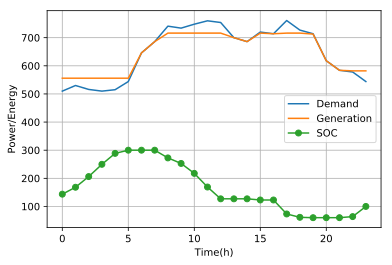

In [20]:
plt.figure()
plt.plot(Pl,label="Demand") 
plt.plot(P.A.flatten(),label="Generation") 
plt.plot(SOC.value.A.flatten(),label="SOC",marker = 'o') 
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy')
plt.legend(loc='right')
plt.grid()


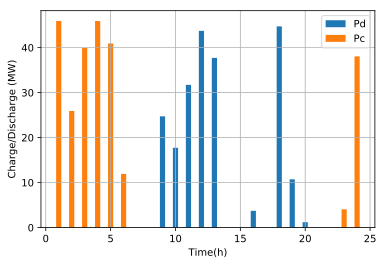

In [21]:
x = range(1,T+1)
plt.figure()
 
plt.bar(x,Pd.value.A.flatten(),label="Pd", width = 0.4) 
plt.bar(x,Pc.value.A.flatten(),label="Pc", width = 0.4) 
plt.xlabel('Time(h)')
plt.ylabel('Charge/Discharge (MW)')
plt.legend(loc='upper right')
plt.grid()

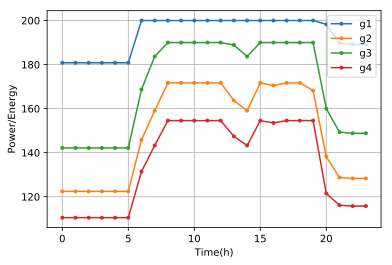

In [22]:
plt.figure()
plt.plot(p[0,:].value.A.flatten(),label="g1", marker = '.') 
plt.plot(p[1,:].value.A.flatten(),label="g2", marker = '.') 
plt.plot(p[2,:].value.A.flatten(),label="g3", marker = '.')
plt.plot(p[3,:].value.A.flatten(),label="g4", marker = '.')
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy')
plt.legend(loc='upper right')
plt.grid()

In [42]:
print(prob.solve_time)

AttributeError: 'Problem' object has no attribute 'solve_time'